# 定义web搜索agent流程图

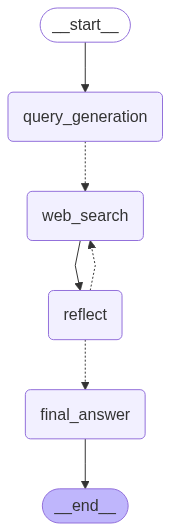

In [3]:
from IPython.core.display import Image
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from langgraph.types import Send
from langgraph.graph import START,END
from typing import Annotated, TypedDict,List
from langgraph.graph import add_messages
from langchain_core.messages import AIMessage,HumanMessage,ToolMessage
from pydantic import BaseModel,Field
import operator
import warnings
warnings.filterwarnings("ignore")

from prompt import(
    query_writer_instructions,
    reflection_instructions,
    answer_instructions
)
from util import get_research_topic

import os

# ==================== 初始化llm模型 ====================
llm = ChatOpenAI(
    model="qwen-plus-latest"   ,
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY"),
    max_retries=2,
)

# ==================== 定义State，定义节点之间的状态传递 ====================
class State(TypedDict):
    messages:Annotated[list,add_messages]
    search_query:Annotated[list,operator.add]
    web_search_result:Annotated[list,operator.add]
    # sources_gathered:Annotated[list,operator.add]
    search_query_count:int # 一次循环能查询的次数 
    max_research_loops:int # 最大循环次数
    research_loop_count:int # 当前循环次数
    final_answer:str # 最终答案
    
class ReflectionState(TypedDict):
    is_sufficient:bool
    knowledge_needed:str
    follow_up_queries:Annotated[list,operator.add]
    research_loop_count:int # 循环次数
    max_research_loops:int # 最大循环次数
    
class Query(TypedDict):
    query:str
    explanation:str
    
class QueryGenerationState(TypedDict):
    search_query: list[Query]
    
class WebSearchState(TypedDict):
    search_query: str
    # id: str

# ==================== 定义llm返回的schema，获取结构化结果 ====================
class SearchQueryList(BaseModel):
    query:List[str] = Field(
        description="A list of search queries to be used for web research."
    )
    explanation:str = Field(
        description="A brief explanation of why these queries are relevant to the research topic."
    )
    
class ReflectionModel(BaseModel):
    is_sufficient:bool = Field(
        description="Whether the gathered sources are sufficient to answer the research question."
    )
    knowledge_needed:str = Field(
        description="A description of what information is missing or needs clarification."
    )
    follow_up_queries:List[str] = Field(
        description="A list of follow-up queries to be used to gather more information."
    )
    

# ===================== 定义需要用到的工具 =====================
from datetime import datetime
# Get current date in a readable format
def get_current_date():
    return datetime.now().strftime("%B %d, %Y")

from langchain_tavily import TavilySearch
tavily_search = TavilySearch(
    max_results = 2,
    api_key= os.getenv("TAVILY_API_KEY")
)
# 定义节点 query generation -> web search -> reflection -> 回到websearch
#                                                      |-> 返回最终answer
def generate_query(state:State):
    """生成查询"""
    current_date = get_current_date()
    research_topic = get_research_topic(state["messages"])
    query_prompt = query_writer_instructions.format(
        current_date=current_date,
        research_topic=research_topic,
        number_queries=state["search_query_count"]
    )

    search_query_llm = llm.with_structured_output(SearchQueryList)
    
    resp = search_query_llm.invoke(query_prompt)
    return {"search_query":resp.query}

def continue_to_web_search(state:QueryGenerationState):
    """将query list并行发送到web search，最后自动在web search汇总"""  
    return [
        Send(
            "web_search",
            {
                "search_query":search_query,
                # "id":int(idx)
                }
            )
        for idx,search_query in enumerate(state['search_query'])
    ]
    
def web_search(state:WebSearchState):
    """网络搜索节点，使用tavily搜索，返回搜索结果"""
    # 使用tavily搜索
    search_results = tavily_search.invoke(state["search_query"])
    results = search_results['results']
    """
    # results是一个字典列表，每个字典包含以下键值对:
    {
      title: str,
      content: str,
      url: str, 
      score: float
    }
    """
    # print(f'执行网络查询','='*30)
    web_search_results = [result['content'] for result in results]
    return {
        "web_search_result":web_search_results
    }
    
def reflect(state:State):
    """反思节点，判断是否需要继续查询"""
    state['research_loop_count'] = state.get('research_loop_count',0) + 1
    
    # print('='*20,f'网络搜索循环当前次数：{state["research_loop_count"] }','='*20)
    
    current_date = get_current_date()
    formatted_prompt = reflection_instructions.format(
        current_date=current_date,  
        research_topic=get_research_topic(state["messages"]),
        # todo
        summaries = "\n\n--\n\n".join(state["web_search_result"])
    )
    
    reflection_llm = llm.with_structured_output(ReflectionModel)
    resp = reflection_llm.invoke(formatted_prompt)
    return {
        "is_sufficient":resp.is_sufficient,
        "knowledge_needed":resp.knowledge_needed,
        "follow_up_queries":resp.follow_up_queries,
        "research_loop_count":state["research_loop_count"], # 更新：循环次数+1
    }
    
# 条件边，用来评估是否需要继续查询
def evaluate_query(state:ReflectionState)->State:
    """通过反思结果和已经执行的查询循环次数来决定是继续搜索还是结束查询"""
    # print(f'============= max_search_loops:{state.get("max_research_loops",None)} =============')
    max_search_loops = state.get("max_research_loops",2)
    
    if state["is_sufficient"] or state["research_loop_count"] >= max_search_loops:
        return "final_answer"
    else:
        return [
            Send(
                "web_search",
                {
                    "search_query":follow_up_query
                }
            )
            for follow_up_query in state["follow_up_queries"]
        ]

def final_answer(state:State):
    """最终答案节点，根据反思结果和搜索结果生成最终答案"""
    current_date = get_current_date()
    formatted_prompt = answer_instructions.format(
        current_date=current_date,  
        research_topic=get_research_topic(state["messages"]),
        summaries = "\n\n--\n\n".join(state["web_search_result"]),
    )
    
    response = llm.invoke(formatted_prompt)
    return {
        "messages":[AIMessage(content=response.content)]
    }
    
    
# ==================== 定义StateGraph ====================

graph_builder = StateGraph(State)
# 添加节点
graph_builder.add_node("query_generation",generate_query)
graph_builder.add_node("web_search",web_search)
graph_builder.add_node("reflect",reflect)
graph_builder.add_node("final_answer",final_answer)
# 添加边
graph_builder.add_edge(START,"query_generation")
graph_builder.add_conditional_edges(
    "query_generation",
    continue_to_web_search,
    ["web_search"]
)
graph_builder.add_edge("web_search","reflect")
graph_builder.add_conditional_edges(
    "reflect",
    evaluate_query,
    ["final_answer","web_search"]
)
graph_builder.add_edge("final_answer",END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# 流式运行，每个节点打印结果

In [4]:
inital_state = {
    "messages":"langgraph是什么",
    "search_query_count":1,
    "max_research_loops":2
}
for event  in graph.stream(inital_state):
    print(event)


{'query_generation': {'search_query': ['LangGraph 是什么 2025 最新介绍 官方文档 功能特点']}}
{'web_search': {'web_search_result': ['LangGraph 是由LangChain团队开发的开源框架，专为构建状态化、多代理（Multi-Agent）系统而设计。它通过图结构（Graph）实现复杂的动态工作流，尤其擅长与', '* 番剧 * 直播 * 游戏中心 * 会员购 * 漫画 * 赛事 您当前的浏览器不支持 HTML5 播放器 制作不易，麻烦各位观众老爷一键三连呀【点赞、投币、收藏】感谢支持～ AI大模型视频配套笔记、80万字面试宝典： AI 人工智能 计算机 LangGraph LangGraph大模型 智能体 计算机技术 ARG Agent智能体 楼兰架构师 发消息 关注 2141 期货开户如何选择合理手续费的期货公司？ 东吴期货有限公司;) 视频选集 （1/9） 自动连播 LangGraph0-课程介绍 langgraph1-快速了解LangGraph langgraph2-使用LangGraph构建Agent智能体\\_上 langgraph3-使用LangGraph构建Agent智能体\\_下 langgraph4-LangGraph接入MCP langgraph5-深度理解Graph\\_上 langgraph7-使用LangGraph构建多智能体工作流 langgraph6-深度理解Graph\\_下 langgraph8-零帧起手，实现多智能体工作流 【吊打付费】目前B站最全最细的LangGraph大模型全套教程，包含所有干货！这还没人看! 我不更了！！ AI大模型学习教程 AI大模型全套教程（LLM+RAG+Langchain+国产大模型ChatGLM-4+NLP新模型Transformer+DeepSeek部署）-马士兵 马士兵官方账号 55.1万 2025最新B站最全最细的Langchain+LangGraph+MCP智能体开发实战教程，全程干货无废话 大模型有温度 2.7万 600分钟吃透最新LangGraph大模型从入门到LangGraph+MCP+RAG医疗行业多智能体实战教程全程干货,一天学完,让你少走99%的弯路！ 图灵课堂VIP 202

# 一次运行，保存结果

In [5]:
import json
state = graph.invoke(inital_state)
state.pop("messages") 

# 将state字典保存到result.json文件
with open('result.json', 'w', encoding='utf-8') as f:
    json.dump(state, f, ensure_ascii=False, indent=4)
